In [59]:
from typing import Annotated, Dict, Any
import json
from typing_extensions import TypedDict

# Langgraph imports
# Mainly defines how to build the graph
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages, BaseMessage
from langchain.globals import set_verbose
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


# LLM imports
from langchain_ollama import ChatOllama
from langchain_ollama.llms import OllamaLLM

from open_eval.prompt_templates import (
    eval_steps_template,
    extract_facts, 
    extract_assertions, 
    generic_criteria_template, 
    rubric_template
)



In [ ]:
# llm = OllamaLLM(model="gpt-oss:20b", verbose=True)
# llm = OllamaLLM(model="llama3:8b", verbose=True)
# llm = OllamaLLM(model="gemma3:4b", verbose=True)
llm = OllamaLLM(model="gemma3:1b", verbose=True)

# from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
# from dotenv import load_dotenv
# import os
# load_dotenv()

# repo_id = "deepseek-ai/DeepSeek-R1-0528"
# repo_id = "meta-llama/Llama-3.3-70B-Instruct"
# hf_llm = HuggingFaceEndpoint(
#     repo_id=repo_id,
#     # max_length=128,
#     temperature=0.5,
#     huggingfacehub_api_token=os.environ["HF_TOKEN"],
#     provider="auto",  # set your provider here hf.co/settings/inference-providers
#     # provider="hyperbolic",
#     # provider="nebius",
#     # provider="together",
# )
# llm = ChatHuggingFace(llm=hf_llm, verbose=True)

# Define the state graph
class State(TypedDict):
    """
    Represents the state passed between evaluation nodes.
    - `messages`: List of LangChain messages representing the chat history.
    - `criteria`: The evaluation criterion (e.g., Helpfulness).
    - `criteria_desc`: Description of the evaluation criterion.
    - `evaluation_steps`: Steps outlining how to perform the evaluation.
    - `result`: Final output from the evaluation process.
    - `rubric`: Scoring rubric for the evaluation.
    - `eval_prompt_template`: Template used to generate the evaluation prompt.
    - `test_case`: Dictionary containing input, response, and context for testing.
    - `prompt`: The constructed prompt for the LLM.
    - `results`: Dictionary containing the evaluation results.
    """
    messages: Annotated[list[BaseMessage], "add_messages"]  # add_messages tells Graph to append
    criteria: str
    criteria_desc: str
    evaluation_steps: list[str]
    result: str
    rubric: Dict[str, Any]
    eval_prompt_template : str
    test_case : Dict[str, Any]
    prompt : str
    results : Dict[str, Any]


def extract_message(result):
    if hasattr(result, 'content'):
        return result.content
    elif isinstance(result, str):
        return result
    else:
        raise ValueError("Result does not have content attribute or is not a string.")
    
def run_evaluation(state: State) -> str:
    criteria = state.get('criteria', 'Helpfulness')
    criteria_desc = state.get('criteria_desc', 'The response should be helpful and provide useful information.')
    return {
        "criteria": criteria,
        "criteria_desc": criteria_desc
    }

def get_eval_steps(state: State) -> str:
    # Extract the evaluation steps from the state
    eval_steps = state.get('evaluation_steps')
    # If they're not already present, generate them
    if eval_steps is None:
        prompt = ChatPromptTemplate.from_template(
            eval_steps_template,
        )
        eval_steps = llm.invoke(prompt.format_messages(**state))
        eval_steps = extract_message(eval_steps)
        start_idx = eval_steps.find("{")          # first occurrence of '{'
        end_idx   = eval_steps.rfind("}")         # last occurrence of '}'
        eval_steps = eval_steps[start_idx + 1:end_idx]
    return {
        "criteria": state.get('criteria'),
        "criteria_desc": state.get('criteria_desc'),
        "evaluation_steps": eval_steps
    }


def generate_rubric(state: State) :
    rubric = state.get('rubric')
    # print (f'rubric: {rubric}')
    if rubric is None:
        prompt = ChatPromptTemplate.from_template(
                rubric_template,
        )
        payload = {
            'criteria' : state.get('criteria'),
            'criteria_desc' : state.get('criteria_desc'),    
            'rubric_min' : 1,
            'rubric_max' : 5
        }
        rubric = llm.invoke(prompt.format_messages(**payload))
        rubric = extract_message(rubric)

        start_idx = rubric.find("[")          # first occurrence of '{'
        end_idx   = rubric.rfind("]")         # last occurrence of '}'
        rubric = rubric[start_idx:end_idx+1]
    return {
        'rubric' : rubric
    }


def get_evaluation_prompt(state: State):
    eval_prompt = state.get('eval_prompt_template')

    payload = {
        'CRITERIA' : state.get('criteria'),
        'CRITERIA_DESCRIPTION' : state.get('criteria_desc'),
        'EVALUATION_STEPS' : state.get('evaluation_steps'),
        'EVALUATION_RUBRIC' : state.get('rubric'),
        'INPUT' : state.get('test_case').get('input', ''),
        'RESPONSE' : state.get('test_case').get('response', ''),
        'CONTEXT' : state.get('test_case').get('context', ''),
        'EXPECTED_RESPONSE' : state.get('test_case').get('expected_response', ''),
    }
    # Remove fields if they don't exist
    if eval_prompt is None:
        template = generic_criteria_template
        if payload['CONTEXT'] == '':
            template = template.replace("CONTEXT: {CONTEXT}", "")
        if payload['EXPECTED_RESPONSE'] == '':
            template = template.replace("EXPECTED RESPONSE: {EXPECTED_RESPONSE}", "")
            
        eval_prompt = ChatPromptTemplate.from_template(
            template,
        )

    return {
        'prompt' : eval_prompt.format_messages(**payload)
    }


def evaluate(state: State):
    prompt = state.get('prompt')
    if prompt is None:
        raise ValueError("Prompt is not set in the state.")
    
    results = llm.invoke(prompt)
    results = extract_message(results)
    start_idx = results.find("{")          # first occurrence of '{'
    end_idx   = results.rfind("}")         # last occurrence of '}'
    results = json.loads(results[start_idx:end_idx+1])
    return {"results" : results}

In [61]:
res = llm.invoke("What is the capital of france")

In [62]:
def build_graph():
    memory = InMemorySaver()

    graph_builder = StateGraph(State, verbose=True)


    # Add the nodes to the graph
    graph_builder.add_node(
        "run_evaluation",
        run_evaluation,
        # inputs=["messages"],
        # outputs=["criteria", "criteria_desc"],
    )

    graph_builder.add_node(
        "get_eval_steps",
        get_eval_steps,
        # inputs=["criteria", "criteria_desc"],
        # outputs=["eval_steps"],
    )

    graph_builder.add_node(
        "get_rubric",
        generate_rubric
    )

    # graph_builder.add_node(
    #     "evaluate_criteria",
    #     evaluate_criteria,
    #     # inputs=["criteria", "test_case"],
    #     # outputs=["result"],
    # )

    graph_builder.add_node(
        "get_evaluation_prompt",
        get_evaluation_prompt,
    )
    graph_builder.add_node(
        "evaluate",
        evaluate,
    )
    graph_builder.add_edge(START, "run_evaluation")
    graph_builder.add_edge("run_evaluation", "get_eval_steps")
    graph_builder.add_edge("get_eval_steps", "get_rubric")
    graph_builder.add_edge("get_rubric", "get_evaluation_prompt")
    graph_builder.add_edge("get_evaluation_prompt", "evaluate")
    graph_builder.add_edge("evaluate", END)
    # Compile the graph
    graph = graph_builder.compile()

    return graph


In [63]:
graph = build_graph()

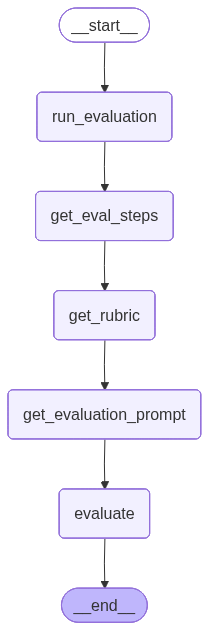

In [64]:
from IPython.display import Image, display
Image(graph.get_graph().draw_mermaid_png(output_file_path="./graph.png"))

In [65]:
# Example: start with a user message we want to evaluate
from langchain_core.messages import HumanMessage

initial_state = {
    # "messages": [HumanMessage(content="How do I reset my router?")],
    "test_case" : {
        "input" : "What is the capital of france",
        "response" : "The capital of france is denmark",
        "context" : "The capital of france is paris. Paris is not located in denmark. Denmark has its own captial",
    }
    # The rest of the keys will be filled by the graph
}

In [66]:
%%time
res = graph.invoke(initial_state)

CPU times: user 131 ms, sys: 15.3 ms, total: 146 ms
Wall time: 50 s


In [67]:
from pprint import pprint
pprint(res['results'])

{'rationale': 'The response directly answers the question with the correct '
              'capital of France – Paris. It also corrects a factual error by '
              'stating that Denmark does not have a capital. The response is '
              'concise and provides the correct answer.',
 'score': '4'}


In [68]:
res = graph.invoke(initial_state)

In [69]:
pprint(res)

{'criteria': 'Helpfulness',
 'criteria_desc': 'The response should be helpful and provide useful '
                  'information.',
 'evaluation_steps': '\n'
                     '    "evaluation_steps": [\n'
                     '        "Read the response carefully to understand the '
                     'topic and purpose.",\n'
                     '        "Assess whether the response directly addresses '
                     'the user\'s question or need.",\n'
                     '        "Evaluate the level of detail and completeness '
                     'of the information provided.",\n'
                     '        "Determine if the response offers actionable '
                     'insights or practical advice.",\n'
                     '        "Gauge the usefulness and relevance of the '
                     'information to the user\'s context.",\n'
                     '        "Consider if the response effectively answers '
                     'the user\'s query and

In [ ]:
requests = [initial_state for i in range(3)]
results = graph.batch(requests)

In [ ]:
for i, res in enumerate(results):
    pprint(res['results'])

{'rationale': 'The response initially states the incorrect capital (Denmark) '
              'and then corrects it to Paris. While it ultimately provides the '
              'correct answer, the initial error and inclusion of inaccurate '
              'information significantly detract from the helpfulness of the '
              'response. A truly helpful response would have provided the '
              'correct answer immediately.',
 'score': '2'}
{'rationale': 'The response initially provides an incorrect answer (Denmark) '
              'and then corrects it to Paris. However, the inclusion of the '
              'extraneous and incorrect statement about Denmark adds to the '
              'unhelpfulness of the response. While the final answer is '
              'correct, the initial error and added detail detract from its '
              'overall helpfulness.',
 'score': '2'}
{'rationale': 'The response initially provides an incorrect answer (denmark) '
              'and then cor